In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime, timedelta
from time import mktime
from google.colab import  drive
from sympy import *
import random
from random import randrange
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

#Helpers
#Cartesian Coordinates relative to earth, conversion implemented from http://faraday.uwyo.edu/~admyers/ASTR5160/handouts/51605.pdf
def convert_cartesian(ra, decl, dist):
  x = dist * np.cos(ra) * np.cos(decl)
  y = dist * np.sin(ra) * np.cos(decl)
  z = dist * np.sin(decl)
  return x.to_numpy(), y.to_numpy(), z.to_numpy()
#Inverse of Cartesian coordinate function, returns cartesian coordinates to ephemeri, RA/DECL/DIST, returns radians or degrees
def convert_ephemeri(x, y , z , radian = True):
  dist = np.sqrt(x**2 + y**2 + z**2)
  ra = np.arctan2(y,x)
  decl = np.arcsin(z/dist)
  #TODO: Finish this
  if radian:
    return ra, decl, dist
  else:
    return math.degrees(ra), math.degrees(decl), dist
#Progress bar helper function
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
#Data Generator
def generate_ephemeri(body, date_range, earth_loc): #generates ephemeri for planets
  out = display(progress(0, periods), display_id=True)
  ras = []
  decs = []
  diss = []
  xs = []
  ys = []
  zs = []
  #Generating dates
  loc = EarthLocation.of_site(earth_loc)

  #Generating Ephemeri's
  i = 0
  for t in date_range:
    i += 1
    t = Time(str(t))
    with solar_system_ephemeris.set('jpl'): #Need jplephem library for this
      b = get_body(body, t, loc)
    ra = b.ra.degree
    dec = b.dec.degree
    dis = b.distance.value
    x, y, z = convert_cartesian(b.ra.radian, b.dec.radian, dis)

    ras.append(ra)
    decs.append(dec)
    diss.append(dis)
    xs.append(x)
    ys.append(y)
    zs.append(z)
    #update prog bar    
    out.update(progress(i, periods))
  data = pd.DataFrame({"Time": date_range, "Right Ascension": ras, "Declination": decs, 'Distance': diss, "X": xs, "Y": ys, "Z": zs})
  return data
def find_cycle(data, time_delta = 20): #returns array of time points where "cycle" occurs
  time = []
  max_val = -1* np.inf
  for i in range(len(data)):
    if data['Right Ascension'][i] > max_val:
      max_val = data['Right Ascension'][i]
    elif ((max_val - data['Right Ascension'][i]) > 300):
      if len(time) == 0:
        max_val = data['Right Ascension'][i]
        time.append(data['Time'][i])
      elif (len(time) > 0) & (data['Time'][i] - time[len(time) - 1] > timedelta(days = time_delta)):
        max_val = data['Right Ascension'][i]
        time.append(data['Time'][i])
  return time
def convert_time(data, normalize = True): #converts time from datetime to epoch, normalize will start at 0
  datacopy = data.copy()
  datacopy['Time'] = datacopy['Time'].apply(lambda x: mktime(x.timetuple()))
  if normalize:
    datacopy['Time'] = datacopy['Time'] - datacopy['Time'][0] #normalize to start time
  return datacopy
def decycle_ra(data, cycles): #adds back 360 at every cycle occurence to make data continuous
  datacopy = data.copy()
  ras = []
  prev_val = data['Right Ascension'][0] #Keeping track of times where the data bobs up and down near 360 degrees, causing false "readditions"
  for i in range(len(data)):
    c = 0
    for t in cycles:
      if data['Time'][i] >= t:
        c += 1
    if data['Right Ascension'][i] - prev_val > 300: #Makes sure we don't add back too many periods
      c -= 1
    else:
      prev_val = data['Right Ascension'][i]
    ra = data['Right Ascension'][i] + 360 * c
    ras.append(ra)
  datacopy['Right Ascension'] = ras
  return datacopy
def estimate_frequency(X, Y): #estimates frequency based on X matrix of time (shape (-1,1)) and Y data of transformed Right Ascension/Declination
  time = []
  peak = -np.inf
  minimum = np.inf
  for i in range(1, len(Y) - 1):
    if Y[i - 1] < Y[i] and Y[i + 1] < Y[i]:
      time.append(X[i])
  sum = 0
  for i in range(len(time)):
    if i > 0:
      sum += time[i] - time[i - 1]
  return (len(time) - 1)*2*np.pi/(sum)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
#read in generated data
parse_dates = ['Time']
mercury = pd.read_csv("../../Data/Mercury2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
venus = pd.read_csv("../../Data/Venus2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
mars = pd.read_csv("../../Data/Mars2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
jupiter = pd.read_csv("../../Data/Jupiter2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
saturn = pd.read_csv("../../Data/Saturn2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
uranus = pd.read_csv("../../Data/Uranus2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
neptune = pd.read_csv("../../Data/Neptune2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)

moon = pd.read_csv("../../Data/Moon2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
sun = pd.read_csv("../../Data/Sun2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)

In [ ]:
train = 0.75
val = 0.8

# Predicting Right Ascension:

# Mercury:
Lets start off by examining data for Mercury's orbit from a geocentric point of view.

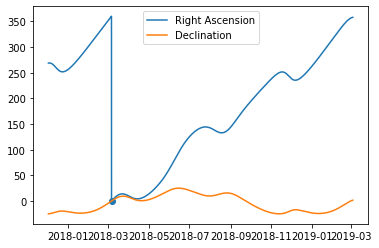

In [ ]:
#Lets look at right ascension and declination over time for mercury
total_train_data = mercury[0:int(train * len(mercury))]
data = total_train_data[0: int(val * len(total_train_data))]
validation = total_train_data[int(val * len(total_train_data)):]

cycles = find_cycle(data)
zeros = np.zeros(len(cycles))
plt.plot(data['Time'], data['Right Ascension'])
plt.plot(data['Time'], data['Declination'])
plt.scatter(cycles, zeros)
plt.legend(['Right Ascension', 'Declination'])

Since we are dealing with angles, every time right ascension goes past 360, a "modulo" is applied in a functional sense, so in order to make this data continuous, we can add back 360 after every "cycle" where right ascension reaches 360 degrees.

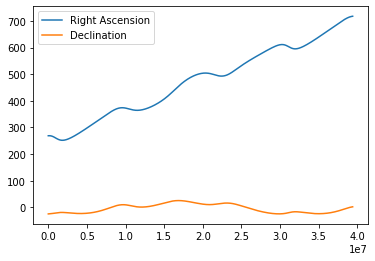

In [ ]:
decycled_data = decycle_ra(data, cycles)
decycled_data = convert_time(decycled_data)
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'])
plt.plot(decycled_data['Time'], decycled_data['Declination'])
plt.legend(['Right Ascension', 'Declination'])

Now we have a continuous function which resembles something of the form $ax + b\sin(cx)$ 

We should try and flatten the function, ie, get rid of the ax term by fitting a linear regression and subtracting from the original data.

---



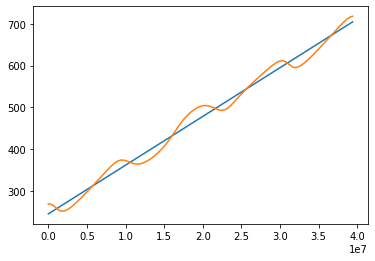

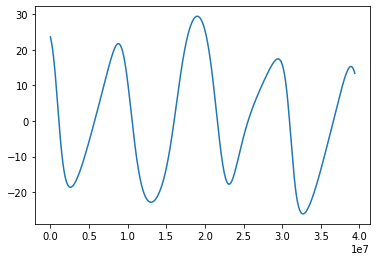

In [ ]:
X = np.array(decycled_data['Time']).reshape(-1,1)
Y = np.array(decycled_data['Right Ascension'])
reg = LinearRegression().fit(X, Y)
y_hat = reg.predict(X)
Y_new = Y - y_hat
plt.plot(X, y_hat)
plt.plot(X, Y)
plt.show()
plt.plot(X, Y_new)

### Fourier feature based approach on transformed data:

define fourier series:
$a_0/2 + \sum_{n=1}^{\infty}a_n\cos(nwt) + \sum_{n=1}^{\infty}b_n\sin(nwt)$

We see that this data is somewhat periodic and looks like it is made of sines and cosines so we can use regression on nonlinear features from a fourier featurization process to see if we can approximate this function well.

**Note**: we could use a fourier transformation to directly find the "true" frequency's present within our curves which is another approach that one of our team members tried, but we can also treat this as a tunable hyperparameter. In our case, we will use an estimation formula using our training data and averaging the distance between peaks as an initial guess and then tune this further via a validation set.

In [ ]:
def fourier_featurize(X, d = 5, freq = 1):
  data = []
  for i in range(d):
    if i == 0:
      data.append(np.cos(i * freq * X).reshape(1,-1)[0])
    else:
      data.append(np.sin(i * freq * X).reshape(1,-1)[0])
      data.append(np.cos(i * freq * X).reshape(1,-1)[0])
  return np.array(data).T
estimate_frequency(X.reshape(len(X)), Y_new)

6.257995415433536e-07

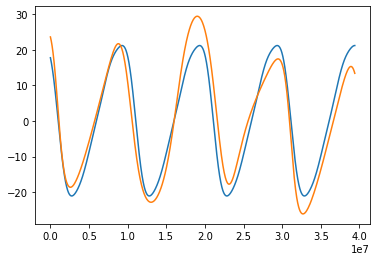

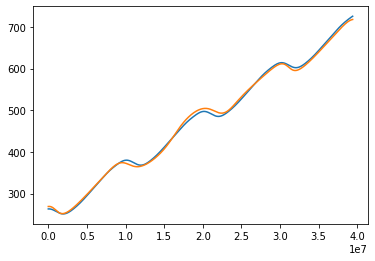

In [ ]:
fourier_features = fourier_featurize(X, 5, freq = 6.257995415433536e-07)
fourier_reg = LinearRegression().fit(fourier_features, Y_new)
y_hat_new = fourier_reg.predict(fourier_features)
plt.plot(X, y_hat_new)
plt.plot(X, Y_new)
plt.show()
plt.plot(X, y_hat_new + y_hat)
plt.plot(X, Y)

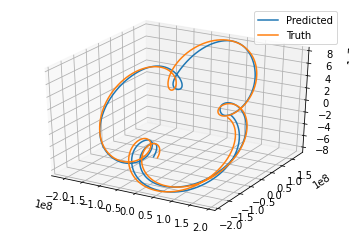

In [ ]:
pred = np.mod(y_hat_new + y_hat, 360)

x1, y1, z1 = convert_cartesian(np.radians(pred), np.radians(data['Declination']), data['Distance'])

x2, y2, z2 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(data['Declination']), data['Distance'])

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])

### Validation:
As we can see, after playing around with the frequency a bit in a "guess and check" manner, we were able to get some pretty good results. While our data in this case doesn't actually have noise, we still need to make sure we didn't overfit our training data and take a look at how this does on a validation set to get a good idea of whether or not we learned the underlying function well and would get useful future predictions.

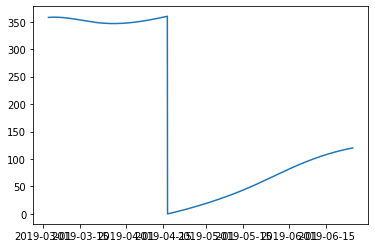

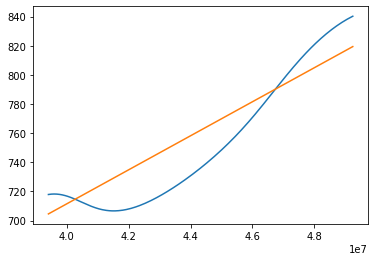

In [ ]:
validation = validation.reset_index()

val_cycles = find_cycle(validation)
val_cycles.extend(cycles) # Need to add on cycles from previous data!

decycled_val = decycle_ra(validation, val_cycles)
decycled_val = convert_time(decycled_val, normalize = False)
decycled_val['Time'] = decycled_val['Time'] - convert_time(data.iloc[[0]], normalize = False)['Time'][0]

plt.plot(validation['Time'], validation['Right Ascension'])
plt.show()
plt.plot(decycled_val['Time'], decycled_val['Right Ascension'])

X_val = np.array(decycled_val['Time']).reshape(-1,1)
Y_val = np.array(decycled_val['Right Ascension'])
y_hat_val = reg.predict(X_val)
plt.plot(X_val, y_hat_val)

We see that our regression line from earlier still fits cuts through pretty nicely which is good since we need to add this back after we do our fourier feature prediction.

Next we'll have to fourier featurize our data again to get it into proper format for predicting via our fourier based regression model.

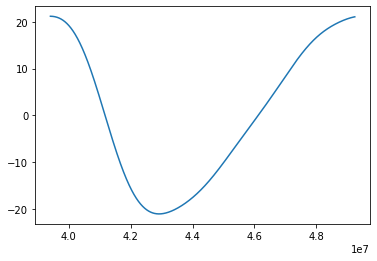

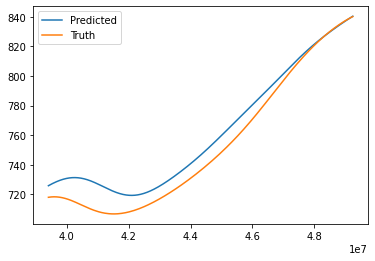

In [ ]:
fourier_features_val = fourier_featurize(X_val, 5, freq = 6.257995415433536e-07)
y_hat_val_new = fourier_reg.predict(fourier_features_val)
plt.plot(X_val, y_hat_val_new)
plt.show()
plt.plot(X_val, y_hat_val_new + y_hat_val)
plt.plot(X_val, Y_val)
plt.legend(['Predicted','Truth'])

As we can see these are some pretty good results on data that the model hasn't seen before so there is definitely potential for prediction within this model format.

In the next few cells, I package all the transformations/regressions into functions so that we can apply this model on all the rest of our planetary data in much fewer lines and do hyper-parameter tuning in a more elegant fashion for each case!

In [ ]:
class transformed_fourier_regression:
  plots = ['t', '3d', 'ra'] # t = transformed, 3d = 3d ephemeri, ra = original rate of ascension data
  def __init__(self, time_delta = 20):
    self.cycles = np.array([])
    self.reg = None
    self.best_fit = None
    self.time_delta = time_delta
  def transform_data(self, data, normalize = True, fit = True): #does all necessary data transformations
    if fit:
      self.ogdata = data
  
    cycle = find_cycle(data, self.time_delta)
    for i in cycle:
      if i not in self.cycles:
        self.cycles = np.append(self.cycles, i)
    data = decycle_ra(data, self.cycles)
    data = convert_time(data, normalize)
    if not normalize:
      data['Time'] = data['Time'] - convert_time(self.ogdata.iloc[[0]], normalize = False)['Time'][0]
    X = np.array(data['Time']).reshape(-1,1)
    Y = np.array(data['Right Ascension'])

    if (fit) & (self.reg is None):
      self.reg = LinearRegression().fit(X, Y)
      y_hat = self.reg.predict(X)
    else:
      y_hat = self.reg.predict(X)
    Y = Y - y_hat
    return X, Y
  def fit(self, data, plot = None, d = 5, freq = 0.0000002, silent = False):
    if plot not in transformed_fourier_regression.plots and plot is not None:
      return print("Specified plot type not valid, use 't', '3d', or 'ra'.")
    self.d = d
    self.freq = freq
    X, Y = self.transform_data(data)
    fourier_features = fourier_featurize(X, d, freq)
    self.fourier_reg = LinearRegression().fit(fourier_features, Y)
    y_hat = self.fourier_reg.predict(fourier_features)
    mse = np.mean((Y - y_hat)**2)
    if plot == 't':
      plt.plot(X, y_hat, zorder=2.5)
      plt.plot(X, Y)
      plt.legend(['Predicted','True'])
      plt.show()
    elif plot == 'ra':
      best_fit = self.reg.predict(X)
      plt.plot(X, y_hat + best_fit, zorder=2.5)
      plt.plot(X, Y + best_fit)
      plt.legend(['Predicted','True'])
      plt.show()
    elif plot == '3d':
      best_fit = self.reg.predict(X)
      pred = np.mod(y_hat + best_fit, 360)

      x1, y1, z1 = convert_cartesian(np.radians(pred), np.radians(data['Declination']), data['Distance'])

      x2, y2, z2 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(data['Declination']), data['Distance'])

      fig = plt.figure()
      ax = fig.gca(projection='3d')
      ax.plot(x1, y1, z1)
      ax.plot(x2, y2, z2)
      plt.legend(['Predicted', 'Truth'])
      plt.show()
    if not silent:
      return mse
    else:
      return self
  def predict(self, data, plot = None, return_val = False):
    if plot not in transformed_fourier_regression.plots and plot is not None:
      return print("Specified plot type not valid, use 't', '3d', or 'ra'.")
    if self.reg is None:
      return print("Must fit data first")
    X, Y = self.transform_data(data, normalize = False, fit = False)
    fourier_features = fourier_featurize(X, self.d, self.freq)
    y_hat = self.fourier_reg.predict(fourier_features)
    best_fit = self.reg.predict(X)
    pred = np.mod(y_hat + best_fit, 360)
    mse = np.mean((Y - y_hat)**2)
    if plot == 't':
      plt.plot(X, y_hat, zorder=2.5)
      plt.plot(X, Y)
      plt.legend(['Predicted','True'])
      plt.show()
    elif plot == 'ra':
      best_fit = self.reg.predict(X)
      plt.plot(X, y_hat + best_fit, zorder=2.5)
      plt.plot(X, Y + best_fit)
      plt.legend(['Predicted','True'])
      plt.show()
    elif plot == '3d':
      x1, y1, z1 = convert_cartesian(np.radians(pred), np.radians(data['Declination']), data['Distance'])

      x2, y2, z2 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(data['Declination']), data['Distance'])

      fig = plt.figure()
      ax = fig.gca(projection='3d')
      ax.plot(x1, y1, z1)
      ax.plot(x2, y2, z2)
      plt.legend(['Predicted', 'Truth'])
      plt.show()
    if return_val:
      return pred, mse
    else:
      return mse

### Hyperparameter Tuning:
Now that we have packaged up our model into a nice form, we can tune our hyperparameters in a convenient fashion to find the best model! We shall go ahead and use grid search for our parameter, frequency and number of fourier features to use.

In [ ]:
freqs = np.linspace(0.00000002, 0.000002, 200)
ds = np.linspace(2, 15, 14, dtype=int)

def hyperparameter_tune(freqs, ds, data, validation, time_delta = 20, declination = False):
  periods = len(freqs) * len(ds)
  errors = []
  i = 0
  out = display(progress(0, periods), display_id=True)
  for f in freqs:
    error = np.array([])
    for d in ds:
      i += 1
      if declination:
        model = fourier_regression().fit(data, d = d, freq = f, silent = True)
      else:
        model = transformed_fourier_regression(time_delta = time_delta).fit(data, d = d, freq = f, silent = True)
      mse = model.predict(validation)
      error  = np.append(error, mse)
      out.update(progress(i, periods))
    errors.append(error)
  i1, i2 = np.unravel_index(np.nanargmin(errors, axis=None), np.array(errors).shape)
  return freqs[i1], ds[i2]

#hyperparameter_tune(freqs, ds, data, validation)

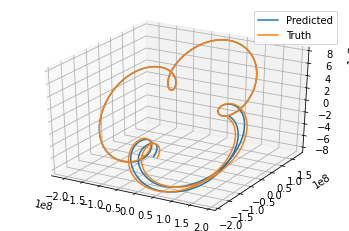

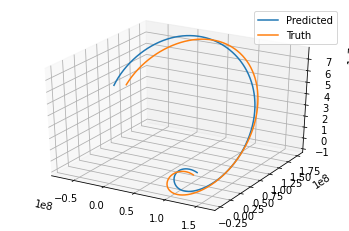

67.8597812734897

In [ ]:
opt_mer_model = transformed_fourier_regression().fit(data, d = 12, freq = 2.0904522613065327e-07, silent = True)
opt_mer_model.predict(data, plot = '3d')
opt_mer_model.predict(validation, plot = '3d')

Thus, we see that with these parameters(freq = 2.0904522613065327e-07, d = 12) this quite a nice prediction model, although not perfect, it will give a rough idea of where Mercury will be in its "orbit around Earth".

Now we have a solid methodology for generating a model for each of the planets in our solar system! We have Mercury already so lets move to the next one in line!

# Venus:

In [ ]:
ven_total_train_data = venus[0:int(train * len(venus))]
ven_data = ven_total_train_data[0: int(val * len(ven_total_train_data))]
ven_validation = ven_total_train_data[int(val * len(ven_total_train_data)):].reset_index()

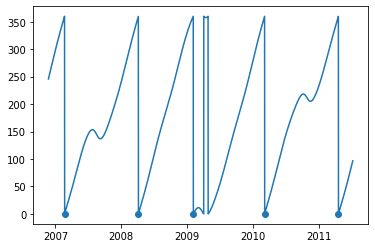

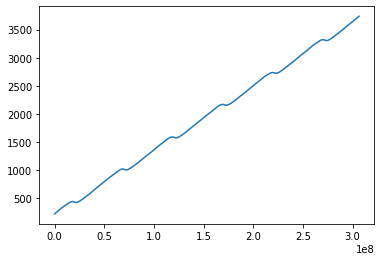

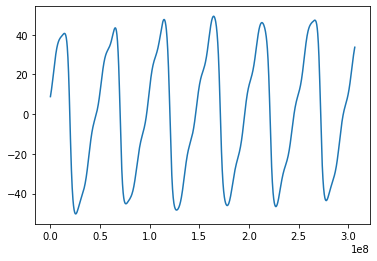

In [ ]:
cycles = find_cycle(ven_data, time_delta = 200)
zeros = np.zeros(len(cycles))
decycled_data = decycle_ra(ven_data, cycles)
decycled_data = convert_time(decycled_data)
best_fit = LinearRegression().fit(np.array(decycled_data['Time']).reshape(-1,1), decycled_data['Right Ascension']).predict(np.array(decycled_data['Time']).reshape(-1,1))
plt.plot(ven_data['Time'][2000:5000], ven_data['Right Ascension'][2000:5000])
plt.scatter(cycles[3:8], zeros[3:8])
plt.show()
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'])
plt.show()
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'] - best_fit)

In [ ]:
estimate_frequency(decycled_data['Time'], decycled_data['Right Ascension'] - best_fit)

4.980665972276444e-07

In [ ]:
#freqs = np.linspace(3.1e-08, 3.18e-08, 20)
#ds = np.linspace(5, 20, 15, dtype=int)

#f, d = hyperparameter_tune(freqs, ds, ven_data, ven_validation, time_delta = 200)
#print(f,d)

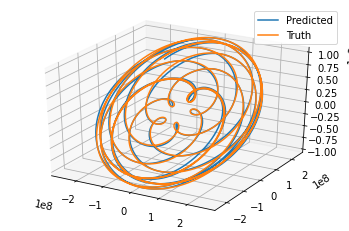

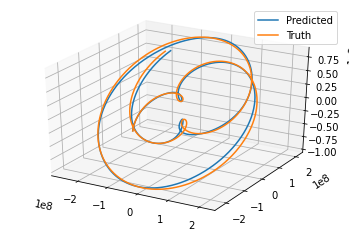

41.803283874485274

In [ ]:
opt_ven_model = transformed_fourier_regression(time_delta = 200)
opt_ven_model.fit(ven_data, d = 17, freq = 3.1126315789473685e-08, plot = '3d')
opt_ven_model.predict(ven_validation, plot = '3d')

# Mars:

In [ ]:
mars_total_train_data = mars[0:int(train * len(mars))]
mars_data = mars_total_train_data[0: int(val * len(mars_total_train_data))]
mars_validation = mars_total_train_data[int(val * len(mars_total_train_data)):].reset_index()

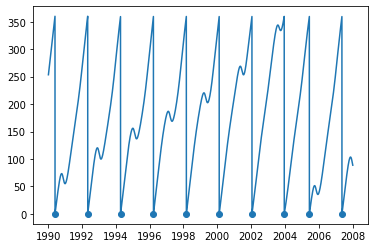

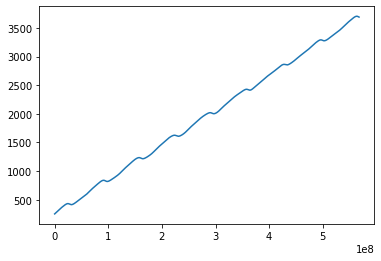

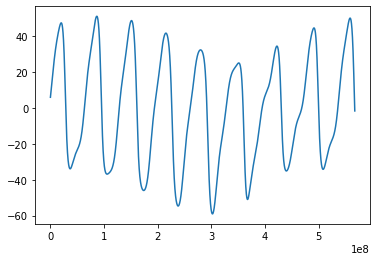

9.329564593675504e-08

In [ ]:
cycles = find_cycle(mars_data)
zeros = np.zeros(len(cycles))
decycled_data = decycle_ra(mars_data, cycles)
decycled_data = convert_time(decycled_data)
best_fit = LinearRegression().fit(np.array(decycled_data['Time']).reshape(-1,1), decycled_data['Right Ascension']).predict(np.array(decycled_data['Time']).reshape(-1,1))
plt.plot(mars_data['Time'], mars_data['Right Ascension'])
plt.scatter(cycles, zeros)
plt.show()
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'])
plt.show()
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'] - best_fit)
plt.show()
estimate_frequency(decycled_data['Time'], decycled_data['Right Ascension'] - best_fit)

In [ ]:
#freqs = np.linspace(9.31e-08, 9.32e-08, 10)
#ds = np.linspace(5, 20, 15, dtype=int)

#f, d = hyperparameter_tune(freqs, ds, mars_data, mars_validation)
#print(f,d)

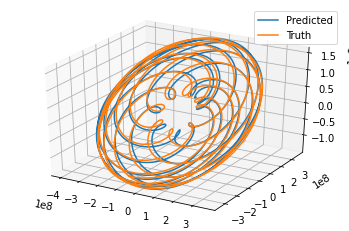

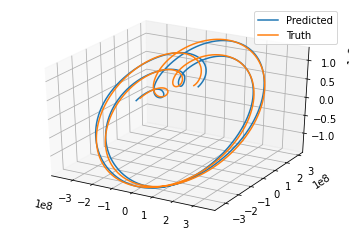

50.252732221970376

In [ ]:
opt_mars_model = transformed_fourier_regression()
opt_mars_model.fit(mars_data, d = 6, freq = 9.32e-08, plot = '3d')
opt_mars_model.predict(mars_validation, plot = '3d')

We have quite good results for Mars even on the validation set which implies our model was able to learn a function which approximates Mars' orbit quite accurately.

# Jupiter:

In [ ]:
jup_total_train_data = jupiter[0:int(train * len(jupiter))]
jup_data = jup_total_train_data[0: int(val * len(jup_total_train_data))]
jup_validation = jup_total_train_data[int(val * len(jup_total_train_data)):].reset_index()

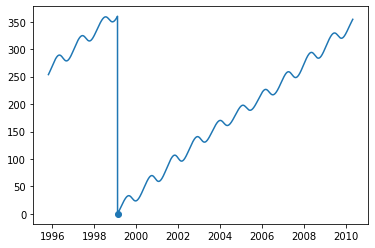

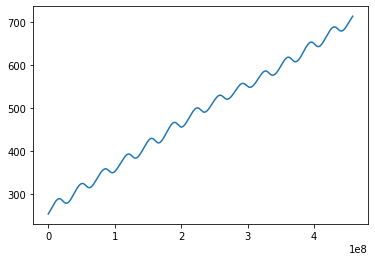

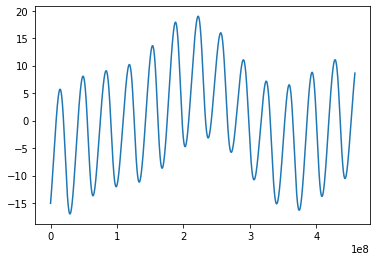

1.8226299058860466e-07

In [ ]:
cycles = find_cycle(jup_data)
zeros = np.zeros(len(cycles))
decycled_data = decycle_ra(jup_data, cycles)
decycled_data = convert_time(decycled_data)
best_fit = LinearRegression().fit(np.array(decycled_data['Time']).reshape(-1,1), decycled_data['Right Ascension']).predict(np.array(decycled_data['Time']).reshape(-1,1))
plt.plot(jup_data['Time'], jup_data['Right Ascension'])
plt.scatter(cycles, zeros)
plt.show()
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'])
plt.show()
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'] - best_fit)
plt.show()
estimate_frequency(decycled_data['Time'], decycled_data['Right Ascension'] - best_fit)

In [ ]:
#freqs = np.linspace(9.1e-08, 9.2e-08, 20)
#ds = np.linspace(5, 15, 10, dtype=int)

#f, d = hyperparameter_tune(freqs, ds, jup_data, jup_validation, time_delta = 800)
#print(f,d)

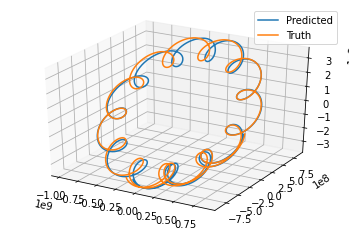

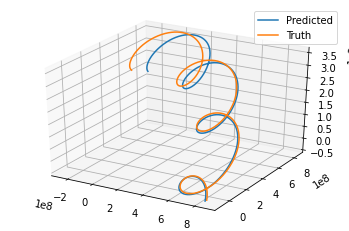

26.44031693084584

In [ ]:
opt_jup_model = transformed_fourier_regression(800)
opt_jup_model.fit(jup_data, d = 8, freq = 9.110526315789473e-08, plot = '3d')
opt_jup_model.predict(jup_validation, plot = '3d')

# Saturn:

In [ ]:
sat_total_train_data = saturn[0:int(train * len(saturn))]
sat_data = sat_total_train_data[0: int(val * len(sat_total_train_data))]
sat_validation = sat_total_train_data[int(val * len(sat_total_train_data)):].reset_index()

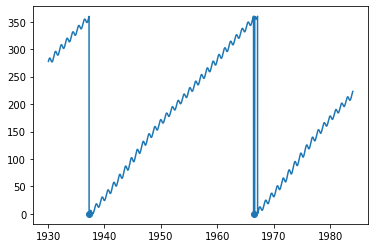

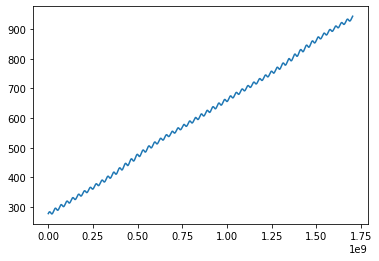

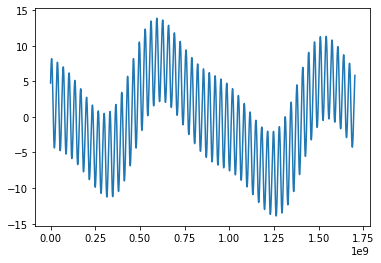

1.922718844359426e-07

In [ ]:
cycles = find_cycle(sat_data, time_delta = 5000)
zeros = np.zeros(len(cycles))
decycled_data = decycle_ra(sat_data, cycles)
decycled_data = convert_time(decycled_data)
best_fit = LinearRegression().fit(np.array(decycled_data['Time']).reshape(-1,1), decycled_data['Right Ascension']).predict(np.array(decycled_data['Time']).reshape(-1,1))
plt.plot(sat_data['Time'], sat_data['Right Ascension'])
plt.scatter(cycles, zeros)
plt.show()
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'])
plt.show()
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'] - best_fit)
plt.show()
estimate_frequency(decycled_data['Time'], decycled_data['Right Ascension'] - best_fit)

In [ ]:
#freqs = np.linspace(7.3e-9, 7.4e-9, 20)
#ds = np.linspace(5, 15, 10, dtype=int)

#f, d = hyperparameter_tune(freqs, ds, jup_data, jup_validation, time_delta=5000)
#print(f,d)

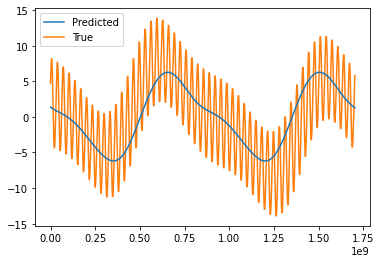

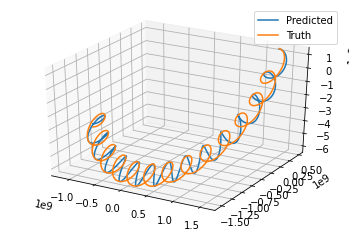

19.965868358103133

In [ ]:
opt_sat_model = transformed_fourier_regression(5000)
opt_sat_model.fit(sat_data, d = 5, freq = 7.4e-9, plot = 't')
opt_sat_model.predict(sat_validation, plot = '3d')

# Uranus:

In [ ]:
ura_total_train_data = uranus[0:int(train * len(uranus))]
ura_data = ura_total_train_data[0: int(val * len(ura_total_train_data))]
ura_validation = ura_total_train_data[int(val * len(ura_total_train_data)):].reset_index()

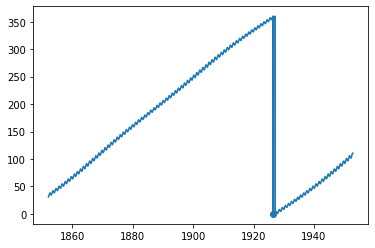

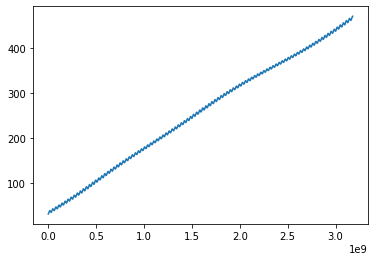

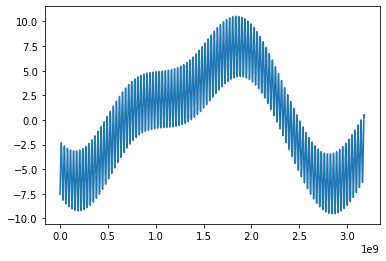

1.967237160015903e-07

In [ ]:
cycles = find_cycle(ura_data, 7000)
zeros = np.zeros(len(cycles))
decycled_data = decycle_ra(ura_data, cycles)
decycled_data = convert_time(decycled_data)
best_fit = LinearRegression().fit(np.array(decycled_data['Time']).reshape(-1,1), decycled_data['Right Ascension']).predict(np.array(decycled_data['Time']).reshape(-1,1))
plt.plot(ura_data['Time'], ura_data['Right Ascension'])
plt.scatter(cycles, zeros)
plt.show()
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'])
plt.show()
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'] - best_fit)
plt.show()
estimate_frequency(decycled_data['Time'], decycled_data['Right Ascension'] - best_fit)

In [ ]:
#freqs = np.linspace(2.3e-9, 2.4e-9, 20)
#ds = np.linspace(5, 15, 10, dtype=int)

#f, d = hyperparameter_tune(freqs, ds, ura_data, ura_validation, time_delta = 7000)
#print(f,d)

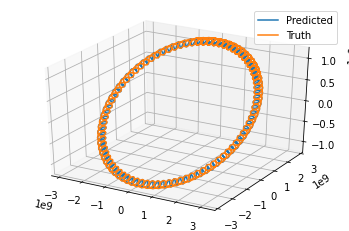

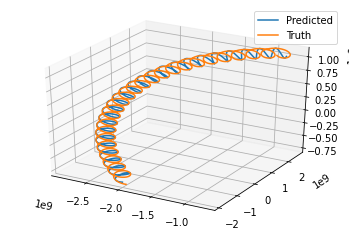

4.570878664959249

In [ ]:
opt_ura_model = transformed_fourier_regression(7000)
opt_ura_model.fit(ura_data, d= 6, freq = 2.3368421052631577e-09, plot = '3d')
opt_ura_model.predict(ura_validation, plot = '3d')

# Neptune:

In [ ]:
nep_total_train_data = neptune[0:int(train * len(neptune))]
nep_data = nep_total_train_data[0: int(val * len(nep_total_train_data))]
nep_validation = nep_total_train_data[int(val * len(nep_total_train_data)):].reset_index()

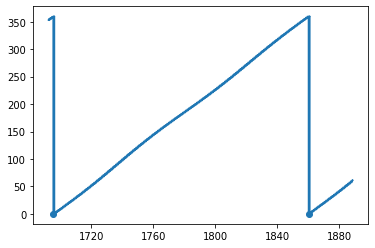

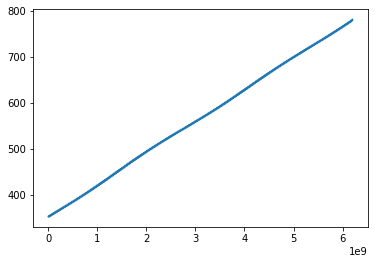

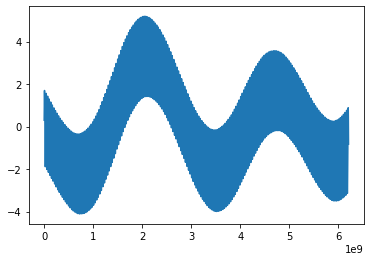

1.9786850969811122e-07

In [ ]:
cycles = find_cycle(nep_data, 20000)
zeros = np.zeros(len(cycles))
decycled_data = decycle_ra(nep_data, cycles)
decycled_data = convert_time(decycled_data)
best_fit = LinearRegression().fit(np.array(decycled_data['Time']).reshape(-1,1), decycled_data['Right Ascension']).predict(np.array(decycled_data['Time']).reshape(-1,1))
plt.plot(nep_data['Time'], nep_data['Right Ascension'])
plt.scatter(cycles, zeros)
plt.show()
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'])
plt.show()
plt.plot(decycled_data['Time'], decycled_data['Right Ascension'] - best_fit)
plt.show()
estimate_frequency(decycled_data['Time'], decycled_data['Right Ascension'] - best_fit)

In [ ]:
#freqs = np.linspace(2.4e-9, 2.5e-9, 20)
#ds = np.linspace(5, 15, 10, dtype=int)

#f, d = hyperparameter_tune(freqs, ds, nep_data, nep_validation, time_delta = 20000)
#print(f,d)

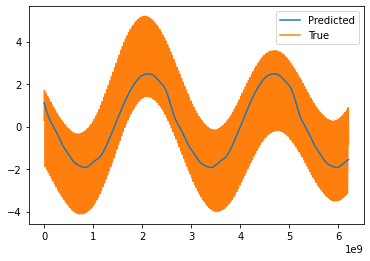

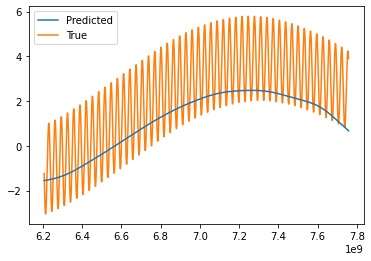

3.3647058911880037

In [ ]:
opt_nep_model = transformed_fourier_regression(20000)
opt_nep_model.fit(nep_data, d= 11, freq = 2.4473684210526316e-09, plot = 't')
opt_nep_model.predict(nep_validation, plot = 't')

# Conclusions about Fourier Features for predicting Right Ascension:

We see that we get quite good predictions for RA in all of our planets with this model with our MSE on validation sets never surpassing 100. The performance in the last 3 planets is particularly good. Even though our prediction does not capture the very high frequency oscillations which occur in the right ascension among these last 3 planets, the model captures the overall sinusoidal pattern, and these high oscillations have such a small magnitude that they ultimately do not affect our predictions very much. In fact, these last three planets have the lowest MSE for our validation set. 

Utlimately, we see, on average, quite a good performance from this fourier feature regression based model, with a better performance for the outer planets then the inner planets. Although this model performs well, we believe there are better models to predict planetary orbits, specifically, since we already know the "true" equation of epicycloids which almost perfectly dictates planetary motion, a better alternative might be to look into fitting these epicycloid functions onto planetary orbit data directly. In fact, this idea is explored by other members of our group in another jupyter notebook and is discussed in our write up.

---
# Fourier Series Regression for Declination:

In [ ]:
class fourier_regression:
  plots = ['d','3d'] # t = transformed, 3d = 3d ephemeri, ra = original rate of ascension data
  def transform_data(self, data, normalize = True, fit = True): #does all necessary data transformations
    if fit:
      self.ogdata = data
    data = convert_time(data, normalize)
    if not normalize:
      data['Time'] = data['Time'] - convert_time(self.ogdata.iloc[[0]], normalize = False)['Time'][0]
    X = np.array(data['Time']).reshape(-1,1)
    Y = np.array(data['Declination'])
    return X, Y
  def fit(self, data, plot = None, d = 5, freq = 0.0000002, silent = False):
    if plot not in fourier_regression.plots and plot is not None:
      return print("Specified plot type not valid, use 'd', '3d'.")
    self.d = d
    self.freq = freq
    X, Y = self.transform_data(data)
    fourier_features = fourier_featurize(X, d, freq)
    self.fourier_reg = LinearRegression().fit(fourier_features, Y)
    y_hat = self.fourier_reg.predict(fourier_features)
    mse = np.mean((Y - y_hat)**2)
    if plot == 'd':
      plt.plot(X, y_hat, zorder=2.5)
      plt.plot(X, Y)
      plt.legend(['Predicted','True'])
      plt.show()
    elif plot == '3d':
      x1, y1, z1 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(y_hat), data['Distance'])

      x2, y2, z2 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(data['Declination']), data['Distance'])

      fig = plt.figure()
      ax = fig.gca(projection='3d')
      ax.plot(x1, y1, z1)
      ax.plot(x2, y2, z2)
      plt.legend(['Predicted', 'Truth'])
      plt.show()
    if not silent:
      return mse
    else:
      return self
  def predict(self, data, plot = None, return_val = False):
    if plot not in fourier_regression.plots and plot is not None:
      return print("Specified plot type not valid, use 'd', '3d'.")
    X, Y = self.transform_data(data, normalize = False, fit = False)
    fourier_features = fourier_featurize(X, self.d, self.freq)
    y_hat = self.fourier_reg.predict(fourier_features)
    mse = np.mean((Y - y_hat)**2)
    if plot == 'd':
      plt.plot(X, y_hat, zorder=2.5)
      plt.plot(X, Y)
      plt.legend(['Predicted','True'])
      plt.show()
    elif plot == '3d':
      x1, y1, z1 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(y_hat), data['Distance'])

      x2, y2, z2 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(data['Declination']), data['Distance'])

      fig = plt.figure()
      ax = fig.gca(projection='3d')
      ax.plot(x1, y1, z1)
      ax.plot(x2, y2, z2)
      plt.legend(['Predicted', 'Truth'])
      plt.show()
    if return_val:
      return y_hat, mse
    else:
      return mse

#Mercury:

In [ ]:
mer_total_train_data = mercury[0:int(train * len(mercury))]
mer_data = mer_total_train_data[0: int(val * len(mer_total_train_data))]
mer_validation = mer_total_train_data[int(val * len(mer_total_train_data)):].reset_index()

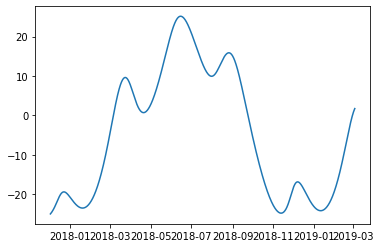

In [ ]:
plt.plot(mer_data['Time'], mer_data['Declination'])

We see that this also seems to demonstrate a cyclical pattern with multiple frequencies added together, although we cannot see the cycle continue fully, we see on the right side that it seems to continue on in a similar fashion so we can assume cyclical nature. Thus, we can again try fourier series to model this, although we cannot reuse our function from previously as that specifically transformed our Right Ascension, something which we no longer need to do for Declination. Thus I will have to rewrite the original function, taking out some of the transformations we needed to do previously.

In [ ]:
#freqs = np.linspace(2.01e-7, 2.09e-7, 20)
#ds = np.linspace(2, 15, 13, dtype = int)

#hyperparameter_tune(freqs, ds, mer_data, mer_validation, declination = True)

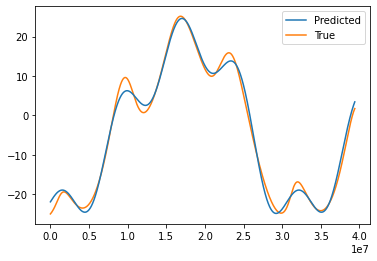

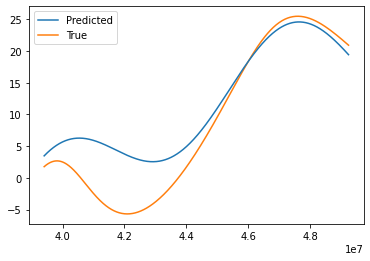

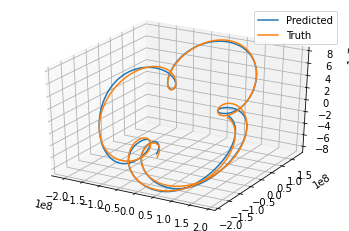

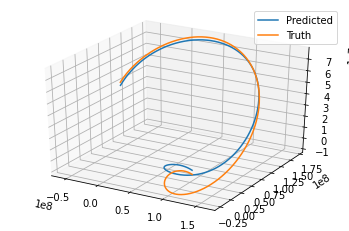

22.818255705707973

In [ ]:
optd_mer_model = fourier_regression().fit(mer_data, d = 5, freq = 2.0521052631578947e-07, silent = True, plot = 'd')
optd_mer_model.predict(mer_validation, plot = 'd')
optd_mer_model.predict(mer_data, plot = '3d')
optd_mer_model.predict(mer_validation, plot = '3d')

# Venus:

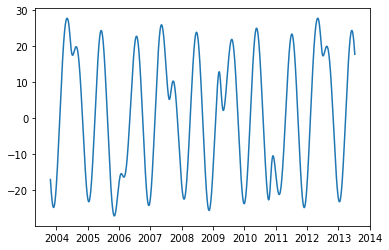

In [ ]:
plt.plot(ven_data['Time'], ven_data['Declination'])

In [ ]:
#freqs = np.linspace(1.99e-7, 2e-7, 20)
#ds = np.linspace(2, 15, 13, dtype = int)

#hyperparameter_tune(freqs, ds, ven_data, ven_validation, declination = True)

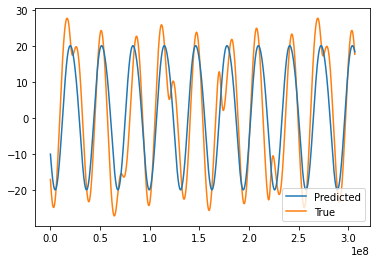

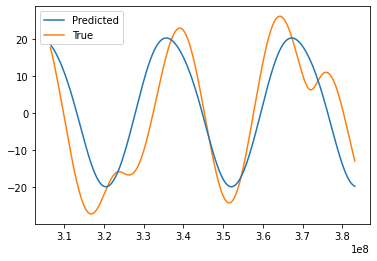

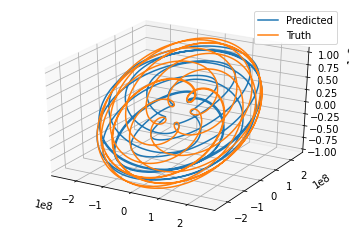

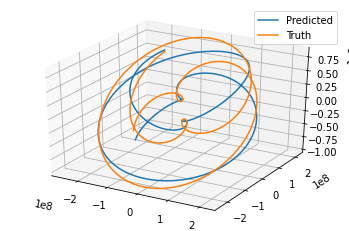

96.58471151738416

In [ ]:
optd_ven_model = fourier_regression().fit(ven_data, d = 4, freq = 1.99e-07, silent = True, plot = 'd')
optd_ven_model.predict(ven_validation, plot = 'd')
optd_ven_model.predict(ven_data, plot = '3d')
optd_ven_model.predict(ven_validation, plot = '3d')

# Mars:

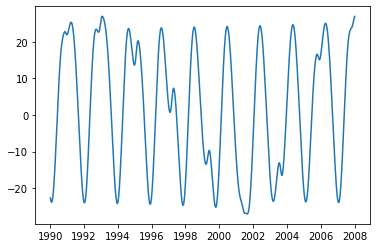

In [ ]:
plt.plot(mars_data['Time'], mars_data['Declination'])

In [ ]:
#freqs = np.linspace(1.51e-8, 1.52e-8, 20)
#ds = np.linspace(2, 15, 13, dtype = int)

#hyperparameter_tune(freqs, ds, mars_data, mars_validation, declination = True)

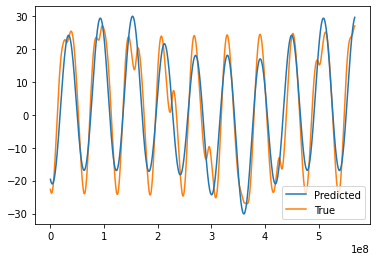

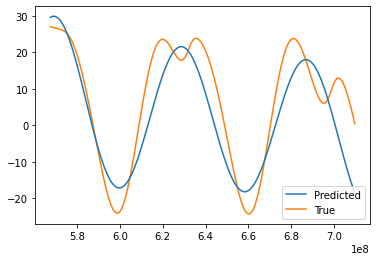

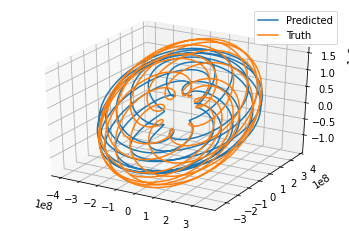

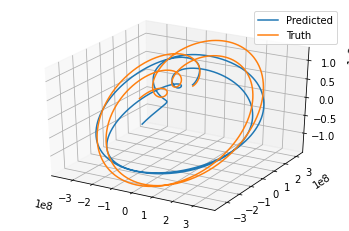

68.88179672610863

In [ ]:
optd_mars_model = fourier_regression().fit(mars_data, d = 8, freq = 1.51e-08, silent = True, plot = 'd')
optd_mars_model.predict(mars_validation, plot = 'd')
optd_mars_model.predict(mars_data, plot = '3d')
optd_mars_model.predict(mars_validation, plot = '3d')

# Jupiter:

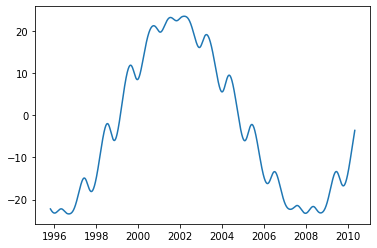

In [ ]:
plt.plot(jup_data['Time'], jup_data['Declination'])

In [ ]:
#freqs = np.linspace(1.65e-8, 1.7e-8, 20)
#ds = np.linspace(2, 15, 13, dtype = int)

#hyperparameter_tune(freqs, ds, jup_data, jup_validation, declination = True)

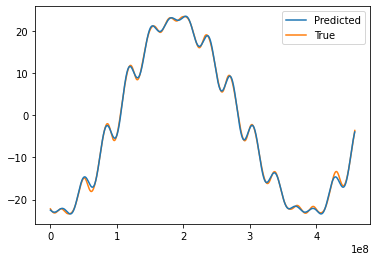

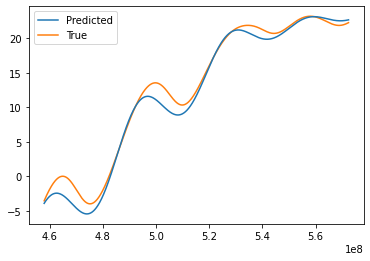

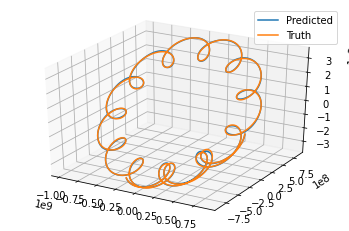

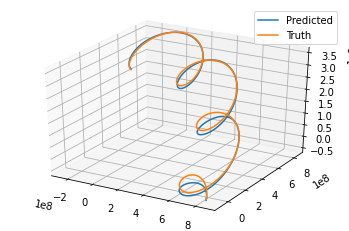

1.6540446001995552

In [ ]:
optd_jup_model = fourier_regression().fit(jup_data, d = 13, freq = 1.6657894736842106e-08, silent = True, plot = 'd')
optd_jup_model.predict(jup_validation, plot = 'd')
optd_jup_model.predict(jup_data, plot = '3d')
optd_jup_model.predict(jup_validation, plot = '3d')

#Saturn:

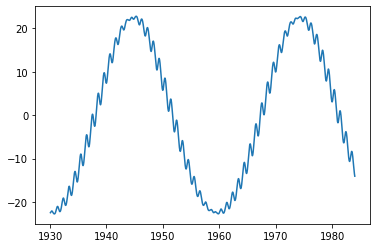

In [ ]:
plt.plot(sat_data['Time'], sat_data['Declination'])

In [ ]:
#freqs = np.linspace(3.3e-09, 3.4e-09, 20)
#ds = np.linspace(2, 15, 13, dtype = int)

#hyperparameter_tune(freqs, ds, sat_data, sat_validation, declination = True)

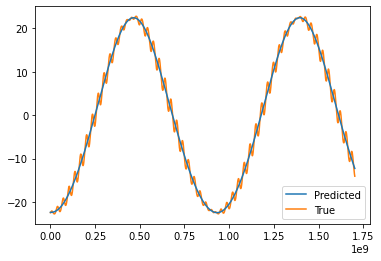

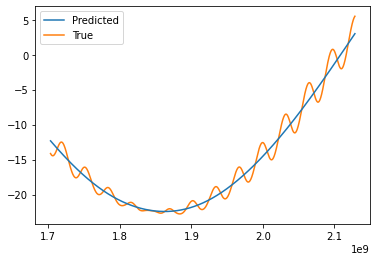

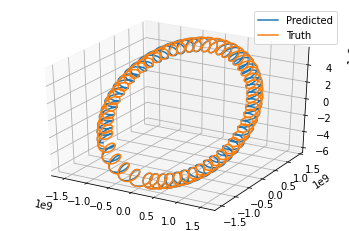

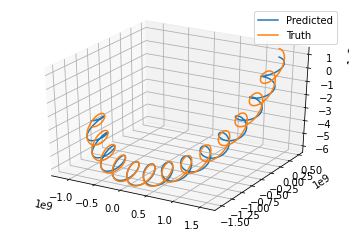

1.295172192405089

In [ ]:
optd_sat_model = fourier_regression().fit(sat_data, d = 15, freq = 3.3789473684210527e-09, silent = True, plot = 'd')
optd_sat_model.predict(sat_validation, plot = 'd')
optd_sat_model.predict(sat_data, plot = '3d')
optd_sat_model.predict(sat_validation, plot = '3d')

#Uranus:

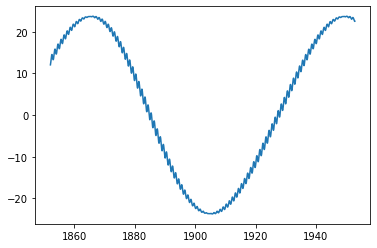

In [ ]:
plt.plot(ura_data['Time'], ura_data['Declination'])

In [ ]:
#freqs = np.linspace(1.32e-9, 1.33e-9, 20)
#ds = np.linspace(2, 15, 13, dtype = int)

#hyperparameter_tune(freqs, ds, ura_data, ura_validation, declination = True)

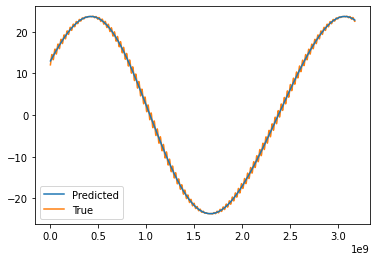

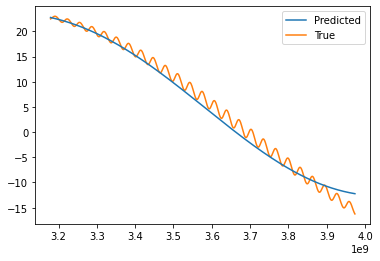

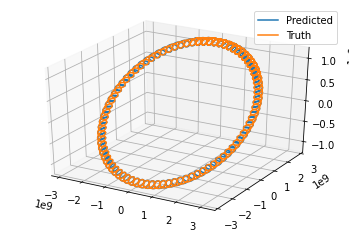

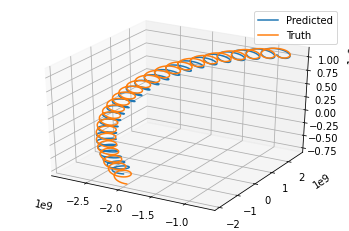

2.052457349800237

In [ ]:
optd_ura_model = fourier_regression().fit(ura_data, d = 7, freq = 1.324736842105263e-09, silent = True, plot = 'd')
optd_ura_model.predict(ura_validation, plot = 'd')
optd_ura_model.predict(ura_data, plot = '3d')
optd_ura_model.predict(ura_validation, plot = '3d')

#Neptune:

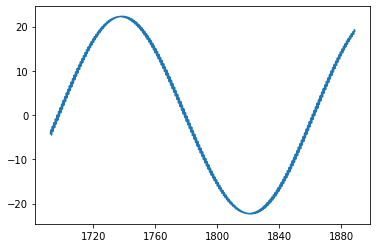

In [ ]:
plt.plot(nep_data['Time'], nep_data['Declination'])

In [ ]:
#freqs = np.linspace(6e-10, 7e-10, 20)
#ds = np.linspace(2, 15, 13, dtype = int)

#hyperparameter_tune(freqs, ds, nep_data, nep_validation, declination = True)

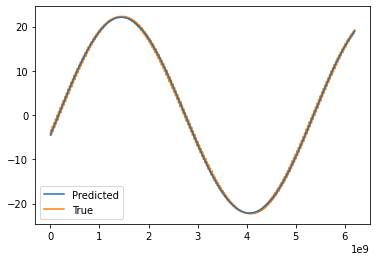

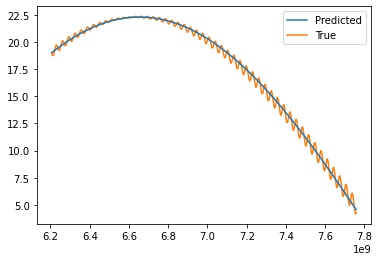

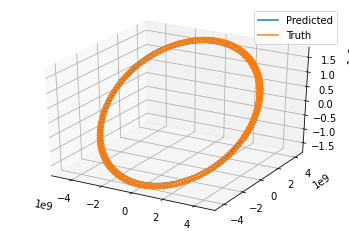

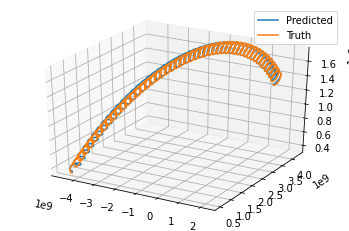

0.12089603993491269

In [ ]:
optd_nep_model = fourier_regression().fit(nep_data, d = 4, freq = 6.105263157894737e-10, silent = True, plot = 'd')
optd_nep_model.predict(nep_validation, plot = 'd')
optd_nep_model.predict(nep_data, plot = '3d')
optd_nep_model.predict(nep_validation, plot = '3d')

---
---
# Moon:

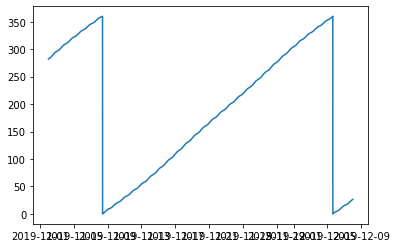

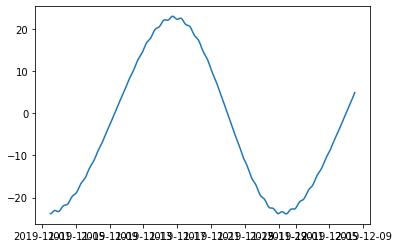

In [ ]:
moon_total_train_data = moon[0:int(train * len(moon))]
moon_data = moon_total_train_data[0: int(val * len(moon_total_train_data))]
moon_validation = moon_total_train_data[int(val * len(moon_total_train_data)):].reset_index()

plt.plot(moon_data['Time'], moon_data['Right Ascension'])
plt.show()
plt.plot(moon_data['Time'], moon_data['Declination'])

### Right Ascension

In [ ]:
#freqs = np.linspace(1.4e-6, 2.5e-6, 20)
#ds = np.linspace(5, 15, 10, dtype=int)

#f, d = hyperparameter_tune(freqs, ds, moon_data, moon_validation)
#print(f,d)

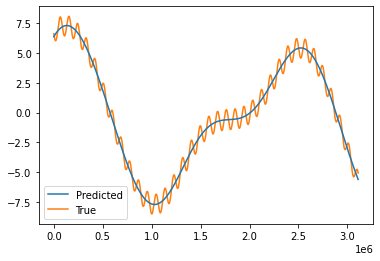

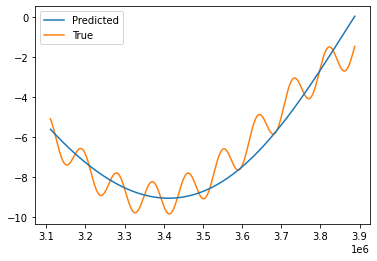

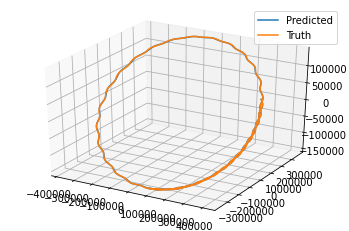

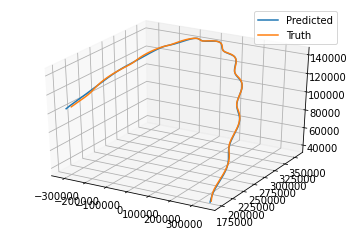

0.7408840985289249

In [ ]:
opt_moon_model = transformed_fourier_regression().fit(moon_data, d= 7, silent = True, freq = 1.5157894736842105e-06, plot = 't')
opt_moon_model.predict(moon_validation, plot = 't')
opt_moon_model.predict(moon_data, plot = '3d')
opt_moon_model.predict(moon_validation, plot = '3d')

### Declination

In [ ]:
#freqs = np.linspace(2.5e-6, 3e-6, 20)
#ds = np.linspace(2, 15, 13, dtype = int)

#hyperparameter_tune(freqs, ds, moon_data, moon_validation, declination = True)

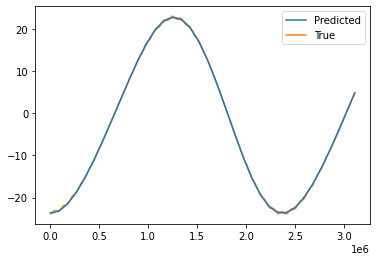

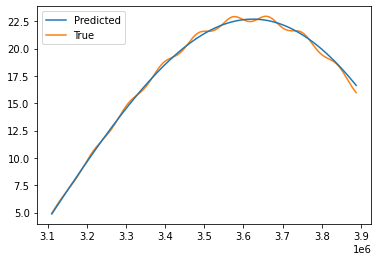

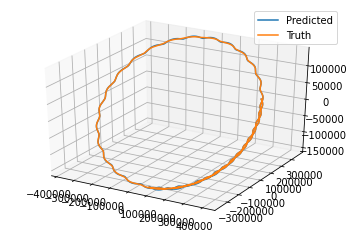

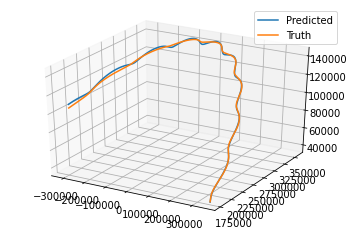

0.0530232349409718

In [ ]:
optd_moon_model = fourier_regression().fit(moon_data, d = 4, freq = 2.6578947368421053e-06, silent = True, plot = 'd')
optd_moon_model.predict(moon_validation, plot = 'd')
optd_moon_model.predict(moon_data, plot = '3d')
optd_moon_model.predict(moon_validation, plot = '3d')

#Sun:

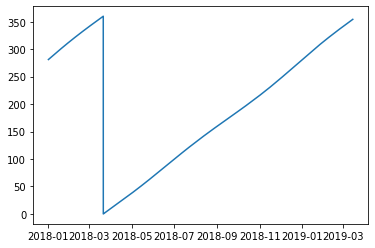

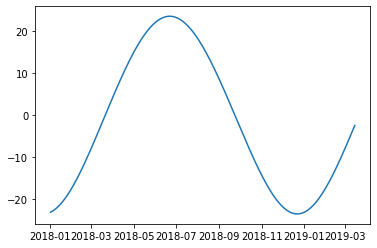

In [ ]:
sun_total_train_data = sun[0:int(train * len(sun))]
sun_data = sun_total_train_data[0: int(val * len(sun_total_train_data))]
sun_validation = sun_total_train_data[int(val * len(sun_total_train_data)):].reset_index()

plt.plot(sun_data['Time'], sun_data['Right Ascension'])
plt.show()
plt.plot(sun_data['Time'], sun_data['Declination'])

### Right Ascension:

In [ ]:
#freqs = np.linspace(1.4e-7, 1.5e-7, 20)
#ds = np.linspace(5, 15, 10, dtype=int)

#f, d = hyperparameter_tune(freqs, ds, sun_data, sun_validation)
#print(f,d)

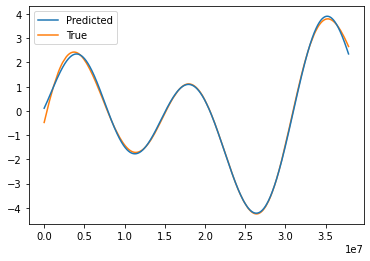

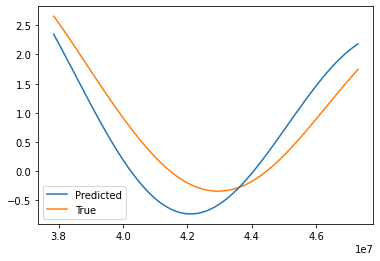

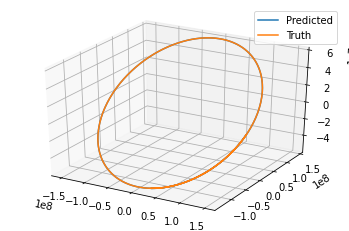

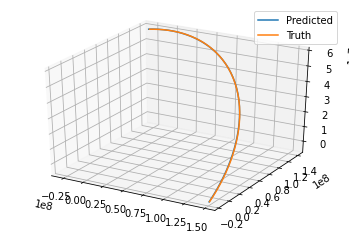

0.26510060737852936

In [ ]:
opt_sun_model = transformed_fourier_regression().fit(sun_data, d= 5, silent = True, freq = 1.4210526315789474e-07, plot = 't')
opt_sun_model.predict(sun_validation, plot = 't')
opt_sun_model.predict(sun_data, plot = '3d')
opt_sun_model.predict(sun_validation, plot = '3d')

### Declination:

In [ ]:
#freqs = np.linspace(5.8e-08, 5.9e-08, 20)
#ds = np.linspace(2, 15, 13, dtype = int)

#hyperparameter_tune(freqs, ds, sun_data, sun_validation, declination = True)

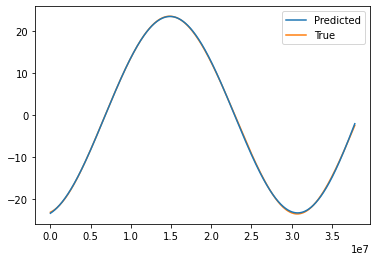

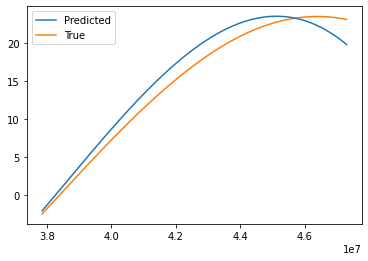

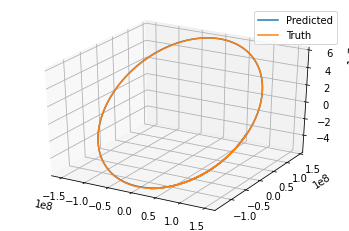

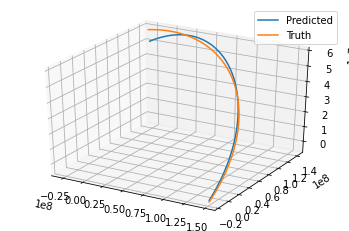

2.5569047047456634

In [ ]:
optd_sun_model = fourier_regression().fit(sun_data, d = 4, freq = 5.884210526315789e-08, silent = True, plot = 'd')
optd_sun_model.predict(sun_validation, plot = 'd')
optd_sun_model.predict(sun_data, plot = '3d')
optd_sun_model.predict(sun_validation, plot = '3d')

#Putting Everything Together:

#### Testing:

In [ ]:
mer_test = mercury[int(train * len(mercury)):].reset_index()
ven_test = venus[int(train * len(venus)):].reset_index()
mars_test = mars[int(train * len(mars)):].reset_index()
jup_test = jupiter[int(train * len(jupiter)):].reset_index()
sat_test = saturn[int(train * len(saturn)):].reset_index()
ura_test = uranus[int(train * len(uranus)):].reset_index()
nep_test = neptune[int(train * len(neptune)):].reset_index()

sun_test = sun[int(train * len(sun)):].reset_index()
moon_test = moon[int(train * len(moon)):].reset_index()

Mercury
RMSE for RA: 8.686623573250591
RMSE for DECL: 3.6461430209266448
3D RMSE: 23680443.644960273


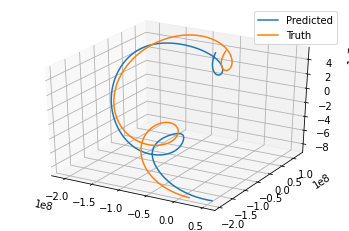

Venus
RMSE for RA: 8.574235020356127
RMSE for DECL: 8.973096013540708
3D RMSE: 36828679.05146988


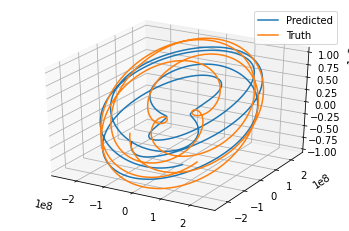

Mars
RMSE for RA: 12.575052608673163
RMSE for DECL: 9.66552524301857
3D RMSE: 51826860.94553318


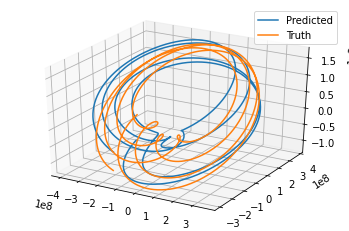

Jupiter
RMSE for RA: 6.418079945417975
RMSE for DECL: 1.088425551438814
3D RMSE: 135627966.42446563


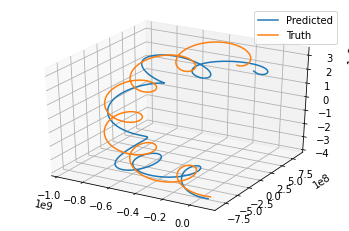

Saturn
RMSE for RA: 7.196229612507645
RMSE for DECL: 1.1653676041128367
3D RMSE: 168976668.42583767


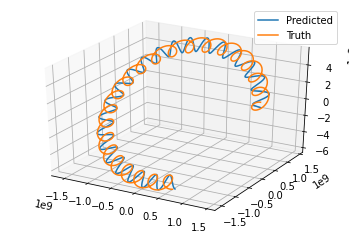

Uranus
RMSE for RA: 2.1975320285678595
RMSE for DECL: 20.132303152438794
3D RMSE: 1042248377.3328224


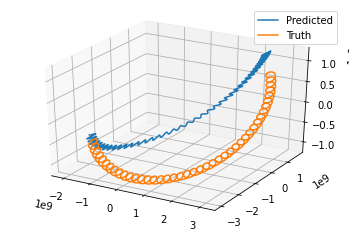

Neptune
RMSE for RA: 1.3615962821832555
RMSE for DECL: 0.7420489309658654
3D RMSE: 119062239.340741


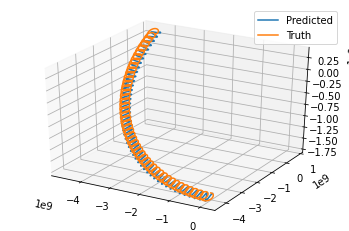

Sun
RMSE for RA: 1.3257950954729298
RMSE for DECL: 81.34616954359042
3D RMSE: 173505617.67217466


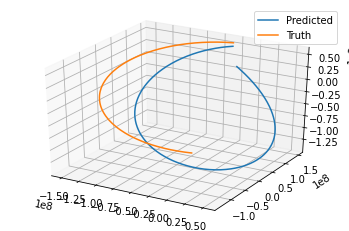

Moon
RMSE for RA: 6.675797290985699
RMSE for DECL: 0.3354945718807392
3D RMSE: 43461.240450872654


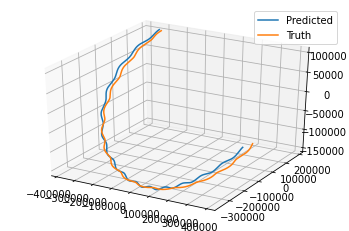

In [ ]:
### Mercury
print('Mercury')
mer_pred_ra, mse1 = opt_mer_model.predict(mer_test,return_val = True )
mer_pred_decl, mse2 = optd_mer_model.predict(mer_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(mer_pred_ra), np.radians(mer_pred_decl), mer_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(mer_test['Right Ascension']), np.radians(mer_test['Declination']), mer_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Venus
print('Venus')
ven_pred_ra, mse1 = opt_ven_model.predict(ven_test,return_val = True )
ven_pred_decl, mse2 = optd_ven_model.predict(ven_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(ven_pred_ra), np.radians(ven_pred_decl), ven_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(ven_test['Right Ascension']), np.radians(ven_test['Declination']), ven_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Mars
print('Mars')
mars_pred_ra, mse1 = opt_mars_model.predict(mars_test,return_val = True )
mars_pred_decl, mse2 = optd_mars_model.predict(mars_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(mars_pred_ra), np.radians(mars_pred_decl), mars_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(mars_test['Right Ascension']), np.radians(mars_test['Declination']), mars_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Jupiter
print('Jupiter')
jup_pred_ra, mse1 = opt_jup_model.predict(jup_test,return_val = True )
jup_pred_decl, mse2 = optd_jup_model.predict(jup_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(jup_pred_ra), np.radians(mer_pred_decl), jup_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(jup_test['Right Ascension']), np.radians(jup_test['Declination']), jup_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Saturn
print('Saturn')
sat_pred_ra, mse1 = opt_sat_model.predict(sat_test,return_val = True )
sat_pred_decl, mse2 = optd_sat_model.predict(sat_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(sat_pred_ra), np.radians(sat_pred_decl), sat_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(sat_test['Right Ascension']), np.radians(sat_test['Declination']), sat_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Uranus
print('Uranus')
ura_pred_ra, mse1 = opt_ura_model.predict(ura_test,return_val = True )
ura_pred_decl, mse2 = optd_ura_model.predict(ura_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(ura_pred_ra), np.radians(ura_pred_decl), ura_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(ura_test['Right Ascension']), np.radians(ura_test['Declination']), ura_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Neptune
print('Neptune')
nep_pred_ra, mse1 = opt_nep_model.predict(nep_test,return_val = True )
nep_pred_decl, mse2 = optd_nep_model.predict(nep_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(nep_pred_ra), np.radians(nep_pred_decl), nep_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(nep_test['Right Ascension']), np.radians(nep_test['Declination']), nep_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Sun
print('Sun')
sun_pred_ra, mse1 = opt_sun_model.predict(sun_test,return_val = True )
sun_pred_decl, mse2 = optd_sun_model.predict(sun_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(sun_pred_ra), np.radians(sun_pred_decl), sun_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(sun_test['Right Ascension']), np.radians(sun_test['Declination']), sun_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Moon
print('Moon')
moon_pred_ra, mse1 = opt_moon_model.predict(moon_test,return_val = True )
moon_pred_decl, mse2 = optd_moon_model.predict(moon_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(moon_pred_ra), np.radians(moon_pred_decl), moon_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(moon_test['Right Ascension']), np.radians(moon_test['Declination']), moon_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()

In [ ]:
'''import pickle
#Right Ascension Models

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_mer.sav'
pickle.dump(opt_mer_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_ven.sav'
pickle.dump(opt_ven_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_mars.sav'
pickle.dump(opt_mars_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_jup.sav'
pickle.dump(opt_jup_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_sat.sav'
pickle.dump(opt_sat_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_ura.sav'
pickle.dump(opt_ura_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_nep.sav'
pickle.dump(opt_nep_model, open(filename, 'wb'))

#Declination models


filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_merd.sav'
pickle.dump(optd_mer_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_vend.sav'
pickle.dump(optd_ven_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_marsd.sav'
pickle.dump(optd_mars_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_jupd.sav'
pickle.dump(optd_jup_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_satd.sav'
pickle.dump(optd_sat_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_urad.sav'
pickle.dump(optd_ura_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/reg_nepd.sav'
pickle.dump(optd_nep_model, open(filename, 'wb'))